# Terrain Preprocessing - Mahsa's Manual Data
### Created by Keenan McConkey 2019.5.17

In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd
print(pd.__version__)

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats

from datetime import datetime
from decimal import Decimal

import pymrmr
import sklearn

0.25.0


## Part 1 - Importing Datasets

### Part (0) - Functions for Data Import

In [2]:
# Easier to read column names
std_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro', 'Run Time', 'Epoch Time',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro']

# Columns not currently used
unused_columns = ['Time Received', 'Timestamp', 'Pitch (Deg)', 'Roll (Deg)', 'Heading (Deg)',
                  'MagX', 'MagY', 'MagZ']

'''Get columns for given label'''
def get_columns(_label):
    
    # Columns are different for synthesis data
    if 'Middle' in _label or 'Left' in _label or 'Right' in _label:
        columns = std_columns.copy()
    elif 'Synthesis' in _label:
        columns = synthesis_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in _label or 'PSD' in _label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [3]:
# Types of terrains, placements, and transforms used
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Left', 'Right', 'Middle', 'Synthesis']
transforms = ['FFT', 'PSD', 'PSDLog']
movements = ['F8', 'Donut', 'Straight']

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

'''Get the transform used for given label'''
def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

### Part (a) - Parsing Data into Pandas

In [4]:
# Find .csv files
raw_datasets = {}
dataset_labels = []
dataset_paths = glob.glob('imu_data/new_setup/set_manual/*.csv')

# Remove 9250 IMU data (for now)
for path in dataset_paths.copy():
    if 'Synthesis' not in path or 'Mahsa' not in path or '9250' in path:
        dataset_paths.remove(path)

In [5]:
# Import datasets as a dictionary of Pandas DataFrames
for dataset_path in dataset_paths:
    
    # Parse labels from filenames
    dataset_label = dataset_path.split('/')[-1].split('.')[0]    
    dataset_labels.append(dataset_label)

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)

    # Drop unused columns
    unused = [unused_column for unused_column in unused_columns if unused_column in dataset.columns]
    dataset = dataset.drop(unused, axis='columns')
    
    # Rename columns to something easier to work with
    dataset.columns = get_columns(dataset_label)

    # Convert timestamps to epoch time in s
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f", ))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Middle data
    ## Can't remove from wheel-mounted Left and Right data because they rotate over time
    if 'Middle' in dataset_label:
        # Remove gravity from z component of acceleration, 
        g_z = 9.81
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - g_z)

    # Remove dropped bytes - i.e. run times below zero
    #dataset = dataset.drop(dataset.loc[dataset['Run Time'] < 0].index.values.tolist())

    # Reorganize synthesis data columns
    if 'Synthesis' in dataset_label:
        dataset_columns = dataset.columns.tolist()
        dataset_columns = dataset_columns[:3] + dataset_columns[5:] + dataset_columns[3:5]
        dataset = dataset[dataset_columns]
    
    # Trim edges to account for start and end time
    STARTUP_THRESH = 2.0
    
    # Different axes to check threshold for synthesis data
    if 'Synthesis' in dataset_label:
        thresh_axes = 'Calc X Accel'
    else:
        thresh_axes = 'Z Accel'
        
    # Caluclate first and last instance above threshold and use at time range
    start_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[0]
    stop_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[-1]
    dataset = dataset[start_index:stop_index]
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [6]:
# Update order of synthesis columns
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro',
                     'Run Time', 'Epoch Time',]

In [7]:
# List all datasets
dataset_labels

['Synthesis_ConcreteDonutMahsa_Module',
 'Synthesis_CarpetStraightMahsa_Module',
 'Synthesis_GrassDonutMahsa_Module',
 'Synthesis_GravelDonutMahsa_Module',
 'Synthesis_AsphaltF8Mahsa_Module',
 'Synthesis_SidewalkF8Mahsa_Module',
 'Synthesis_LinoleumDonutMahsa_Module',
 'Synthesis_ConcreteF8Mahsa_Module',
 'Synthesis_LinoleumF8Mahsa_Module',
 'Synthesis_AsphaltStraightMahsa_Module',
 'Synthesis_LinoleumStraightMahsa_Module',
 'Synthesis_GrassStraightMahsa_Module',
 'Synthesis_GravelF8Mahsa_Module',
 'Synthesis_GravelStraightMahsa_Module',
 'Synthesis_GrassF8Mahsa_Module',
 'Synthesis_ConcreteStraightMahsa_Module',
 'Synthesis_CarpetDonutMahsa_Module',
 'Synthesis_SidewalkStraightMahsa_Module',
 'Synthesis_CarpetF8Mahsa_Module',
 'Synthesis_AsphaltDonutMahsa_Module',
 'Synthesis_SidewalkDonutMahsa_Module']

In [8]:
# Check dataset formatting
raw_datasets[dataset_labels[0]].head()

,Calc X Accel,Calc X Vel,Calc Z Gyro,Left X Accel,Left Y Accel,Left Z Accel,Left XY Accel,Left X Gyro,Left Y Gyro,Left Z Gyro,Right X Accel,Right Y Accel,Right Z Accel,Right XY Accel,Right X Gyro,Right Y Gyro,Right Z Gyro,Run Time,Epoch Time
2219,4.596283,0.063071,0.069112,7.990597,-4.825731,-0.532580,9.334737,0.045492,-0.046086,0.152886,0.425296,-9.868091,1.155269,9.691222,0.023142,-0.178384,-0.722921,6.658,1.564694e+09
2220,0.419000,0.064328,0.071530,8.180933,-4.824534,-0.467938,9.497568,0.046557,-0.050879,0.155017,0.367836,-9.791477,1.273780,9.745996,0.021545,-0.180780,-0.729313,6.661,1.564694e+09
2221,0.549939,0.065977,0.068508,7.961867,-4.854461,-0.349427,9.325080,0.056410,-0.043422,0.163272,0.460011,-9.775915,1.245050,9.805808,0.020213,-0.183177,-0.740765,6.664,1.564694e+09
2222,0.432095,0.067274,0.074703,7.981020,-4.791015,-0.305135,9.308626,0.057209,-0.047151,0.162207,0.439661,-9.785492,1.272583,9.702998,0.024740,-0.187438,-0.749020,6.667,1.564694e+09
2223,0.523751,0.068845,0.075609,8.022918,-4.895162,-0.575675,9.398395,0.052682,-0.053809,0.166734,0.545004,-9.722047,1.340817,9.933381,0.026072,-0.190900,-0.757276,6.670,1.564694e+09


### Part (b) - Visualizing Time Domain Data

In [9]:
'''Plot a single dataset in one direction'''
def plot_one(_datasets, dataset_name, x_axis, y_axis, xlim=None, ylim=None, save_fig=False):
    plt.clf()
    plt.figure(figsize=(10, 5))
    
    plt.plot(_datasets[dataset_name][x_axis], _datasets[dataset_name][y_axis])
    plt.title(dataset_name)
    plt.xlabel(x_axis + ' (s)')
    
    if 'Accel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s^2$)')
    elif 'Gyro' in y_axis:
        plt.ylabel(y_axis + ' ($rad/s$)')
    elif 'Vel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s$)')
    else:
        plt.ylabel('Unknown')
    
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    
    # Save figure to png file without plotting
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/'
        save_name = save_name + y_axis.replace(' ', '_') + '_' + dataset_name + '.png'
        plt.savefig(save_name)
    
    # Just plot without saving
    else:    
        plt.show()

<Figure size 432x288 with 0 Axes>

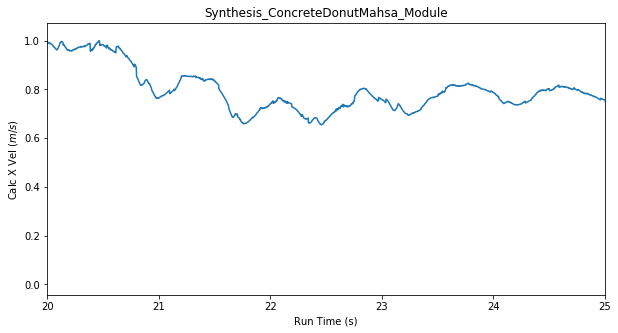

In [10]:
# Plot some raw data
plot_one(raw_datasets, dataset_labels[0], 'Run Time', 'Calc X Vel', xlim=(20, 25))

In [11]:
# Plot every dataset Z Accel and save images
#for label in dataset_labels:
#    plot_one(raw_datasets, label, 'Run Time', 'Z Accel', save_fig=True)

In [12]:
'''Compare two Pandas DataFrames by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, dirn, t_offset=0, y_offset=0):
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    
    # Plot data with given y and t offsetson first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][dirn].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][dirn], label=label2)
    
    ax.set_xlabel('Epoch Time ($s$)')
    if 'Gyro' in dirn:
        ax.set_ylabel(dirn + ' ($rad/s$)')
    elif 'Accel' in dirn:
        ax.set_ylabel(dirn + ' ($m/s^2$)')
    
    ax.set_title(dirn + ' for ' + label1 + ' and ' + label2)
    
    # Plot offset info
    offset_text = 'Offsets\n'
    offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

In [13]:
# Compare Z Gyro data for each wheel in the same dataset
#dataset_compare(raw_datasets, 'Left_ConcreteStraight_Module',
#                raw_datasets, 'Right_ConcreteStraight_Module', 
#                dirn='Z Gyro')

In [14]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):
    plt.clf()
    
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 1
    
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
        
    axes = []
    row, col = 0, 0
    
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis + ' (s)')
        
        if 'Gyro' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($rad/s$)')
        elif 'Accel' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($m/s^2$)')
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

<Figure size 432x288 with 0 Axes>

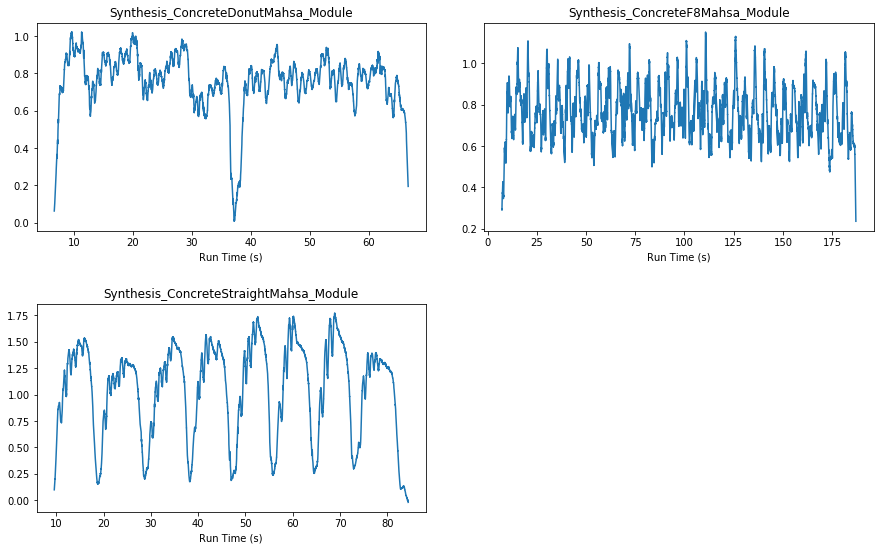

In [15]:
# Plot Z Accel of same dataset for different modules
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() if 'Synthesis' in label and 'Concrete' in label}
plot_all(datasets_to_plot, x_axis='Run Time', y_axis='Calc X Vel')

### Part (c) - Converting Between Pandas and Numpy

In [16]:
'''Convert array of Pandas DataFrames to array of 2D Numpy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # Return passed datasets if they are already NumPy ndarrays
        if type(dataset) is np.ndarray:
            print('Note: Already a NumPy array!')
            return pd_datasets
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.to_numpy()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [17]:
'''Convert array of 2D Numpy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Return passed datasets if they are already Pandas dataframes
        if type(dataset) is pd.DataFrame:
            print('Note: Already a Pandas dataframe!')
            return np_datasets
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))
                
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [18]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [19]:
# Run to convert back to Pandas
#raw_datasets = np_to_pd(raw_datasets)

In [20]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 21
Shape of first dataset: (19997, 19)


#### Data Structure:

`Terrain Dataset Dictionary 
-> NP Array
---> Row = Datapoint, 
---> Col = Direction | Time`

## Part 2 - Preprocessing

In [21]:
'''Get relevant frequencies for given label based on whether its a frame or wheel dataset'''
def get_frequencies(label):
    # Sampling frequency (and thus cutoff frequency) varies between frame and wheel modules
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        f_samp = 333.3 # Sampling frequency
        f_low = 60 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    elif 'Middle' in label:
        f_samp = 300 # Sampling frequency
        f_low = 55 # Low pass cutoff frequency
        f_high = 1 # High pass cutoaff frequency
    else:
        raise Exception('Unknown label format')
        
    return f_samp, f_low, f_high

In [22]:
'''Get window size based on whether label is for a frame or wheel dataset'''
def get_window_size(label):
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        window_size = 333
    elif 'Middle' in label:
        window_size = 300
    else:
        raise Exception('Unknown label format')
    return window_size

In [23]:
def get_n_data_col(label):
    if 'Synthesis' in label:
        n_col = 17
    elif 'Left' in label or 'Right' in label or 'Middle' in label:
        n_col = 6
    else:
        raise Exception('Unknown label format')
    return n_col

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

**Nominally set to 30 % of Nyquist Freq**

In [24]:
# Filtered datasets dictionary
datasets = {}

for label, raw_dataset in raw_datasets.items():
    
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Get normalized frequencies
    w_low = f_low / (f_samp / 2) 
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    # Number of columns containing data
    n_data_col = get_n_data_col(label)
    
    # Filter all the data columns
    dataset = np.copy(raw_dataset)
    for i in range(n_data_col):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, raw_dataset[:, i])
        
    datasets.update({label: dataset})

<Figure size 432x288 with 0 Axes>

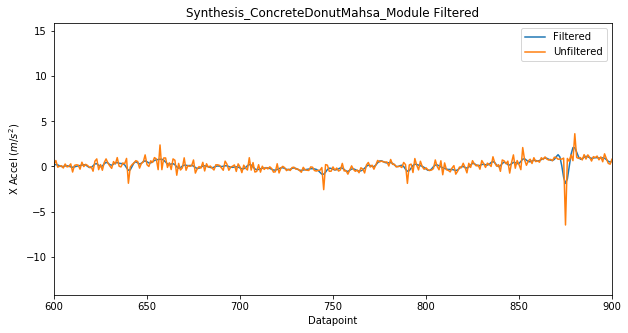

In [25]:
# Compare filtered and unfiltered
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(datasets[dataset_labels[0]][:, 0], label='Filtered')
plt.plot(raw_datasets[dataset_labels[0]][:, 0], label='Unfiltered')
plt.xlim(600, 900)
plt.legend()
plt.xlabel('Datapoint')
plt.ylabel('X Accel ($m/s^2$)')
plt.title(dataset_labels[0] + ' Filtered')
plt.show()

In [26]:
## Check construction
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 21
Shape of first filtered dataset: (19997, 19)


In [27]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

,Calc X Accel,Calc X Vel,Calc Z Gyro,Left X Accel,Left Y Accel,Left Z Accel,Left XY Accel,Left X Gyro,Left Y Gyro,Left Z Gyro,Right X Accel,Right Y Accel,Right Z Accel,Right XY Accel,Right X Gyro,Right Y Gyro,Right Z Gyro,Run Time,Epoch Time
0,4.596230,0.063071,0.069112,7.990733,-4.825664,-0.532627,9.334820,0.045490,-0.046088,0.152887,0.425249,-9.868137,1.155217,9.691197,0.023142,-0.178383,-0.722924,6.658,1.564694e+09
1,1.944925,0.064475,0.069850,8.024600,-4.825620,-0.395586,9.363939,0.050459,-0.046621,0.156996,0.420764,-9.817077,1.227252,9.717867,0.021990,-0.180580,-0.731024,6.661,1.564694e+09
2,0.321234,0.065912,0.071178,8.028080,-4.830640,-0.347711,9.369567,0.054026,-0.047291,0.160697,0.433224,-9.774967,1.277405,9.770436,0.022104,-0.183497,-0.739542,6.664,1.564694e+09
3,-0.056512,0.067346,0.073195,8.010311,-4.842440,-0.419798,9.360410,0.055404,-0.048188,0.163780,0.462937,-9.748425,1.294862,9.842249,0.023447,-0.187347,-0.748652,6.667,1.564694e+09
4,0.240281,0.068689,0.075468,8.007301,-4.857936,-0.554241,9.365772,0.054964,-0.049397,0.166329,0.498682,-9.742066,1.283952,9.888654,0.024819,-0.191691,-0.758230,6.670,1.564694e+09


<Figure size 432x288 with 0 Axes>

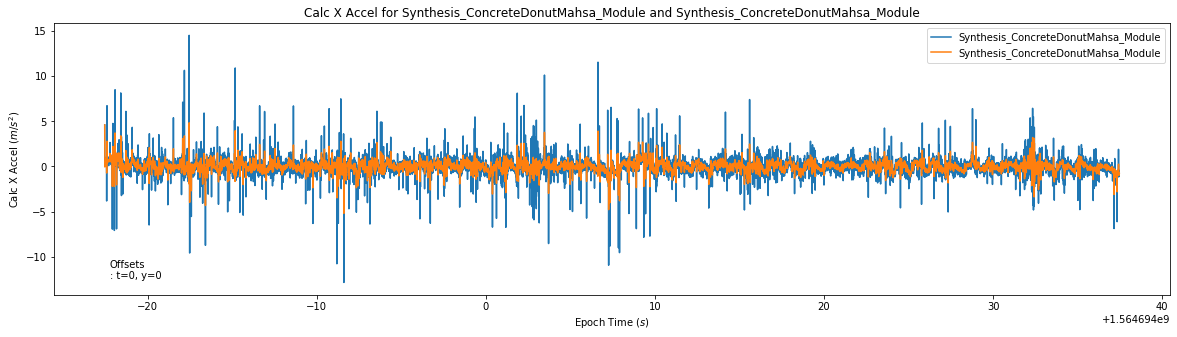

In [28]:
# Again compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), dataset_labels[0], 
                np_to_pd(datasets), dataset_labels[0], 'Calc X Accel')

### Part (b) - Further Time Domain Visualization

In [29]:
'''Compare Z Gyro of frame to calculated value off of two wheels'''
def gyro_compare(dataset, label, xlim=None):
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate Z Gyro off of wheels
    r_wheel = 0.30
    d_base = 0.54
    calc = (r_wheel / d_base)*(-1 * dataset['Left_' + label]['Z Gyro'] - dataset['Right_' + label]['Z Gyro'])
    calc = np.reshape(calc, dataset['Right_' + label]['Epoch Time'].shape)
    
    # Plot actual frame gyro, calculated frame gyro, and actual wheel gyro
    ax.plot(dataset['Middle_' + label]['Epoch Time'], dataset['Middle_' + label]['Z Gyro'], 
            label='Actual Frame')
    ax.plot(dataset['Right_' + label]['Epoch Time'], calc, label='Calculated Frame')
    ax.plot(dataset['Left_' + label]['Epoch Time'], dataset['Left_' + label]['Z Gyro'], 
            label='Actual L Wheel')
    ax.plot(dataset['Right_' + label]['Epoch Time'], dataset['Right_' + label]['Z Gyro'],
            label='Actual R Wheel')
    
    # Other figure stuff
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel('Z Gyro ($m/s^2$)')
    ax.set_title('Comparing Actual to Calculated Z Gyro Data')
    
    if xlim:
        start_time = dataset['Middle_' + label]['Epoch Time'][0]
        ax.set_xlim(xlim[0] + start_time, xlim[1] + start_time)
    ax.legend()
    plt.show()

In [30]:
#gyro_compare(np_to_pd(datasets), 'ConcreteDonutKevin_Module', xlim=(20, 40))

### Part (c) - Integrating Data from Three Modules

In [31]:
# Go through Left and Right datasets and integrate into one dataset
'''
for terrain in terrains:
    for movement in movements:
        # Identifier at end of label
        label_suffix = terrain + movement + '_Module'
        
        # Set index to epoch time for easier time alignment
        left = datasets['Left_' + label_suffix].set_index('Epoch Time')
        right = datasets['Right_' + label_suffix].set_index('Epoch Time')
        middle = datasets['Middle_' + label_suffix + '6050'].set_index('Epoch Time')
        synthesis = datasets['Synthesis_' + label_suffix].set_index('Epoch Time')
        
        # Join the wheel data columns, only where they overlap in Epoch Time
        dataset_wheels = pd.concat([left, right], axis=1, join='inner')
        dataset_wheels = dataset_wheels.reset_index()
        
        # Save as a csv and add to dataset dictionary
        wheels_label = 'Wheels_' + label_suffix
        dataset_wheels.to_csv('imu_data/' + wheels_label + '.csv', index=False)
        datasets.update({wheels_label: dataset_wheels})
        
        # Join data from all the "placements", only where they overlap in Epoch Time
        dataset_all = pd.concat([left, right, middle, synthesis], axis=1, join='inner')
        dataset_all = dataset_all.reset_index()
        
        # Save as csv and add to dictionary
        all_label = 'All_' + label_suffix
        dataset_all.to_csv('imu_data/' + all_label + '.csv')
        datasets.update({all_label: dataset_all})
'''

'\nfor terrain in terrains:\n    for movement in movements:\n        # Identifier at end of label\n        label_suffix = terrain + movement + \'_Module\'\n        \n        # Set index to epoch time for easier time alignment\n        left = datasets[\'Left_\' + label_suffix].set_index(\'Epoch Time\')\n        right = datasets[\'Right_\' + label_suffix].set_index(\'Epoch Time\')\n        middle = datasets[\'Middle_\' + label_suffix + \'6050\'].set_index(\'Epoch Time\')\n        synthesis = datasets[\'Synthesis_\' + label_suffix].set_index(\'Epoch Time\')\n        \n        # Join the wheel data columns, only where they overlap in Epoch Time\n        dataset_wheels = pd.concat([left, right], axis=1, join=\'inner\')\n        dataset_wheels = dataset_wheels.reset_index()\n        \n        # Save as a csv and add to dataset dictionary\n        wheels_label = \'Wheels_\' + label_suffix\n        dataset_wheels.to_csv(\'imu_data/\' + wheels_label + \'.csv\', index=False)\n        datasets.up

In [32]:
# Only process new integrated data for now
#datasets = {label: dataset for label, dataset in datasets.items() if 'All' in label or 'Wheels' in label}
#dataset_labels = list(datasets.keys())

## Part 3 - Time Windows

### Part (a) - Creating Time Windowed Data

In [33]:
datasets_windowed = {}

# Trim excess datapoints, then split into windows
for label, dataset in datasets.items():
    window_size = get_window_size(label)
    n_windows = int(len(dataset) / window_size) # Note: Integer floor
    n_points = n_windows * window_size
    
    dataset_windowed = np.resize(dataset, (n_points, dataset.shape[1]))
    dataset_windowed = np.split(dataset_windowed, n_windows, axis=0)
    
    datasets_windowed.update({label: dataset_windowed})

In [34]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 21
Num of windows in first dataset: 60
Shape of individual window: (333, 19)


In [35]:
# Try out pandas conversion again
np_to_pd(datasets_windowed, windowed=True)[dataset_labels[0]][0].tail()

,Calc X Accel,Calc X Vel,Calc Z Gyro,Left X Accel,Left Y Accel,Left Z Accel,Left XY Accel,Left X Gyro,Left Y Gyro,Left Z Gyro,Right X Accel,Right Y Accel,Right Z Accel,Right XY Accel,Right X Gyro,Right Y Gyro,Right Z Gyro,Run Time,Epoch Time
328,0.823525,0.724612,0.724155,-0.372635,-8.870549,-1.522442,9.146757,-0.028689,-0.760652,1.818074,7.547740,7.194535,-0.202944,10.800471,0.454619,0.198101,-3.017621,7.642,1.564694e+09
329,0.412496,0.725850,0.728131,0.935638,-8.965543,-1.006061,9.116292,-0.032597,-0.742509,1.818766,7.679582,7.478255,-0.195467,10.519851,0.448710,0.200959,-3.012548,7.645,1.564694e+09
330,-0.127270,0.725469,0.738174,1.094362,-9.665325,-0.295901,9.744948,-0.049755,-0.737580,1.808621,7.719063,7.693870,-0.083562,10.300810,0.442556,0.203563,-3.006171,7.648,1.564694e+09
331,-0.112393,0.725132,0.747462,0.172473,-10.404844,-0.007325,10.482371,-0.067223,-0.742868,1.799293,7.587700,7.758195,0.007290,10.252630,0.435710,0.205718,-2.999371,7.651,1.564694e+09
332,0.461881,0.726517,0.748439,-1.030189,-10.561983,-0.388929,10.673028,-0.068262,-0.746005,1.803130,7.341492,7.714280,-0.001676,10.341960,0.427254,0.206844,-2.992986,7.654,1.564694e+09


<Figure size 432x288 with 0 Axes>

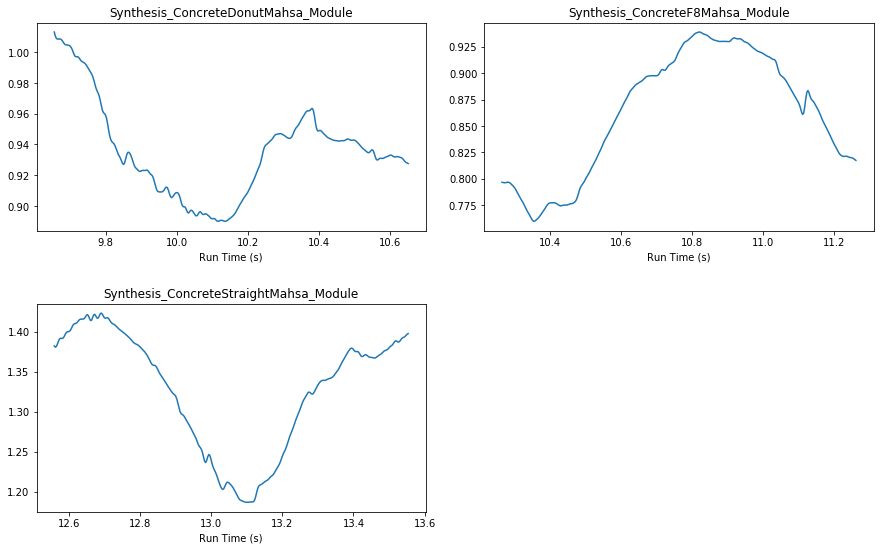

In [36]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items() if 'Concrete' in label}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Run Time', y_axis='Calc X Vel', windowed=True, win_num=3)

#### Data Structure

`Terrain Dataset Dictionary
-> Data Window List
---> NP Array
-----> Row = Datapoint
-----> Col = Direction | Time`

## Part 4 - Transforms

In [37]:
'''Plot tranform of given direction and window of a windowed dataset dictionary'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)
    plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + get_columns(label)[dirn] + ', Window {}')
    plt.show()

### Part (a) - FFT

In [38]:
datasets_fft = {}
N_BINS_OVER_CUTOFF = 5 # Number of frequency bins past the cutoff frequency to include

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Sampling frequency dependent on device
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_fft = np.zeros((n_bins, n_data_col))
        
        for i in range(n_data_col):
            # FFT is normalized to window size, to ensure consistency between different size choices
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), window_size)), n_bins)
            
        # Get positive frequency bins for given FFT parameters
        freq_col = np.transpose([np.resize(np.fft.fftfreq(window_size, 1 / f_samp), n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + 'FFT': dataset_fft})

In [39]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[4]+'FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[4]+'FFT'][0].shape))

# Pandas conversion
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'FFT'][0].head()

Num of FFT'd windowed datasets: 21
Num of FFT'd windows in first dataset: 180
Shape of FFT'd individual window: (64, 18)


,Calc X Accel,Calc X Vel,Calc Z Gyro,Left X Accel,Left Y Accel,Left Z Accel,Left XY Accel,Left X Gyro,Left Y Gyro,Left Z Gyro,Right X Accel,Right Y Accel,Right Z Accel,Right XY Accel,Right X Gyro,Right Y Gyro,Right Z Gyro,Frequency
0,0.680425,0.400488,0.350500,5.670221,6.998796,0.528730,9.507535,0.155242,0.368408,1.048671,6.325850,4.533755,0.646195,9.971849,0.386815,0.264022,2.177974,0.000000
1,0.042073,0.114324,0.086342,1.295781,0.946482,0.019821,0.046226,0.060171,0.135834,0.313218,2.165573,3.154482,0.249796,0.092861,0.147710,0.144051,0.455268,1.000901
2,0.078979,0.059163,0.049172,0.752180,0.448889,0.020877,0.022827,0.014429,0.055643,0.157800,0.653653,1.356667,0.097063,0.056894,0.050191,0.044062,0.176718,2.001802
3,0.030361,0.035870,0.026115,0.542129,0.291279,0.031377,0.018749,0.011016,0.025240,0.100911,0.361826,0.997100,0.099965,0.047250,0.046762,0.021768,0.151806,3.002703
4,0.048353,0.026535,0.019106,0.428481,0.223132,0.044251,0.022870,0.009828,0.018401,0.074011,0.318084,0.883306,0.077949,0.025738,0.021138,0.024088,0.087099,4.003604


<Figure size 432x288 with 0 Axes>

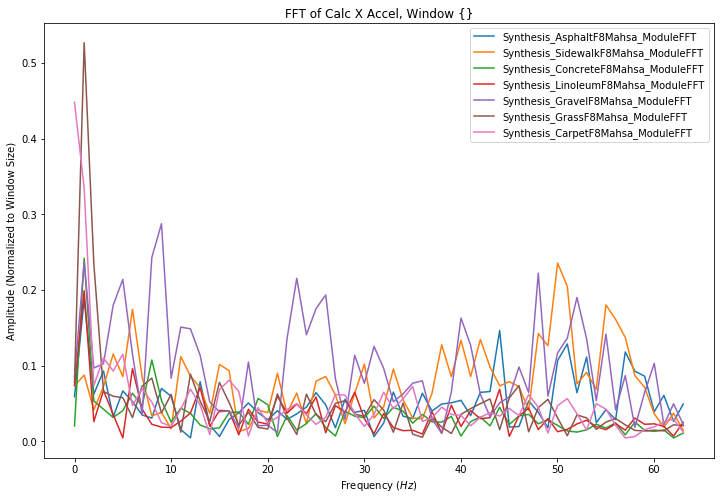

In [40]:
# Plot Middle Z Accel of 10th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(ffts_to_plot, win_num=3, dirn=0, transform_name='FFT')

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

<Figure size 432x288 with 0 Axes>

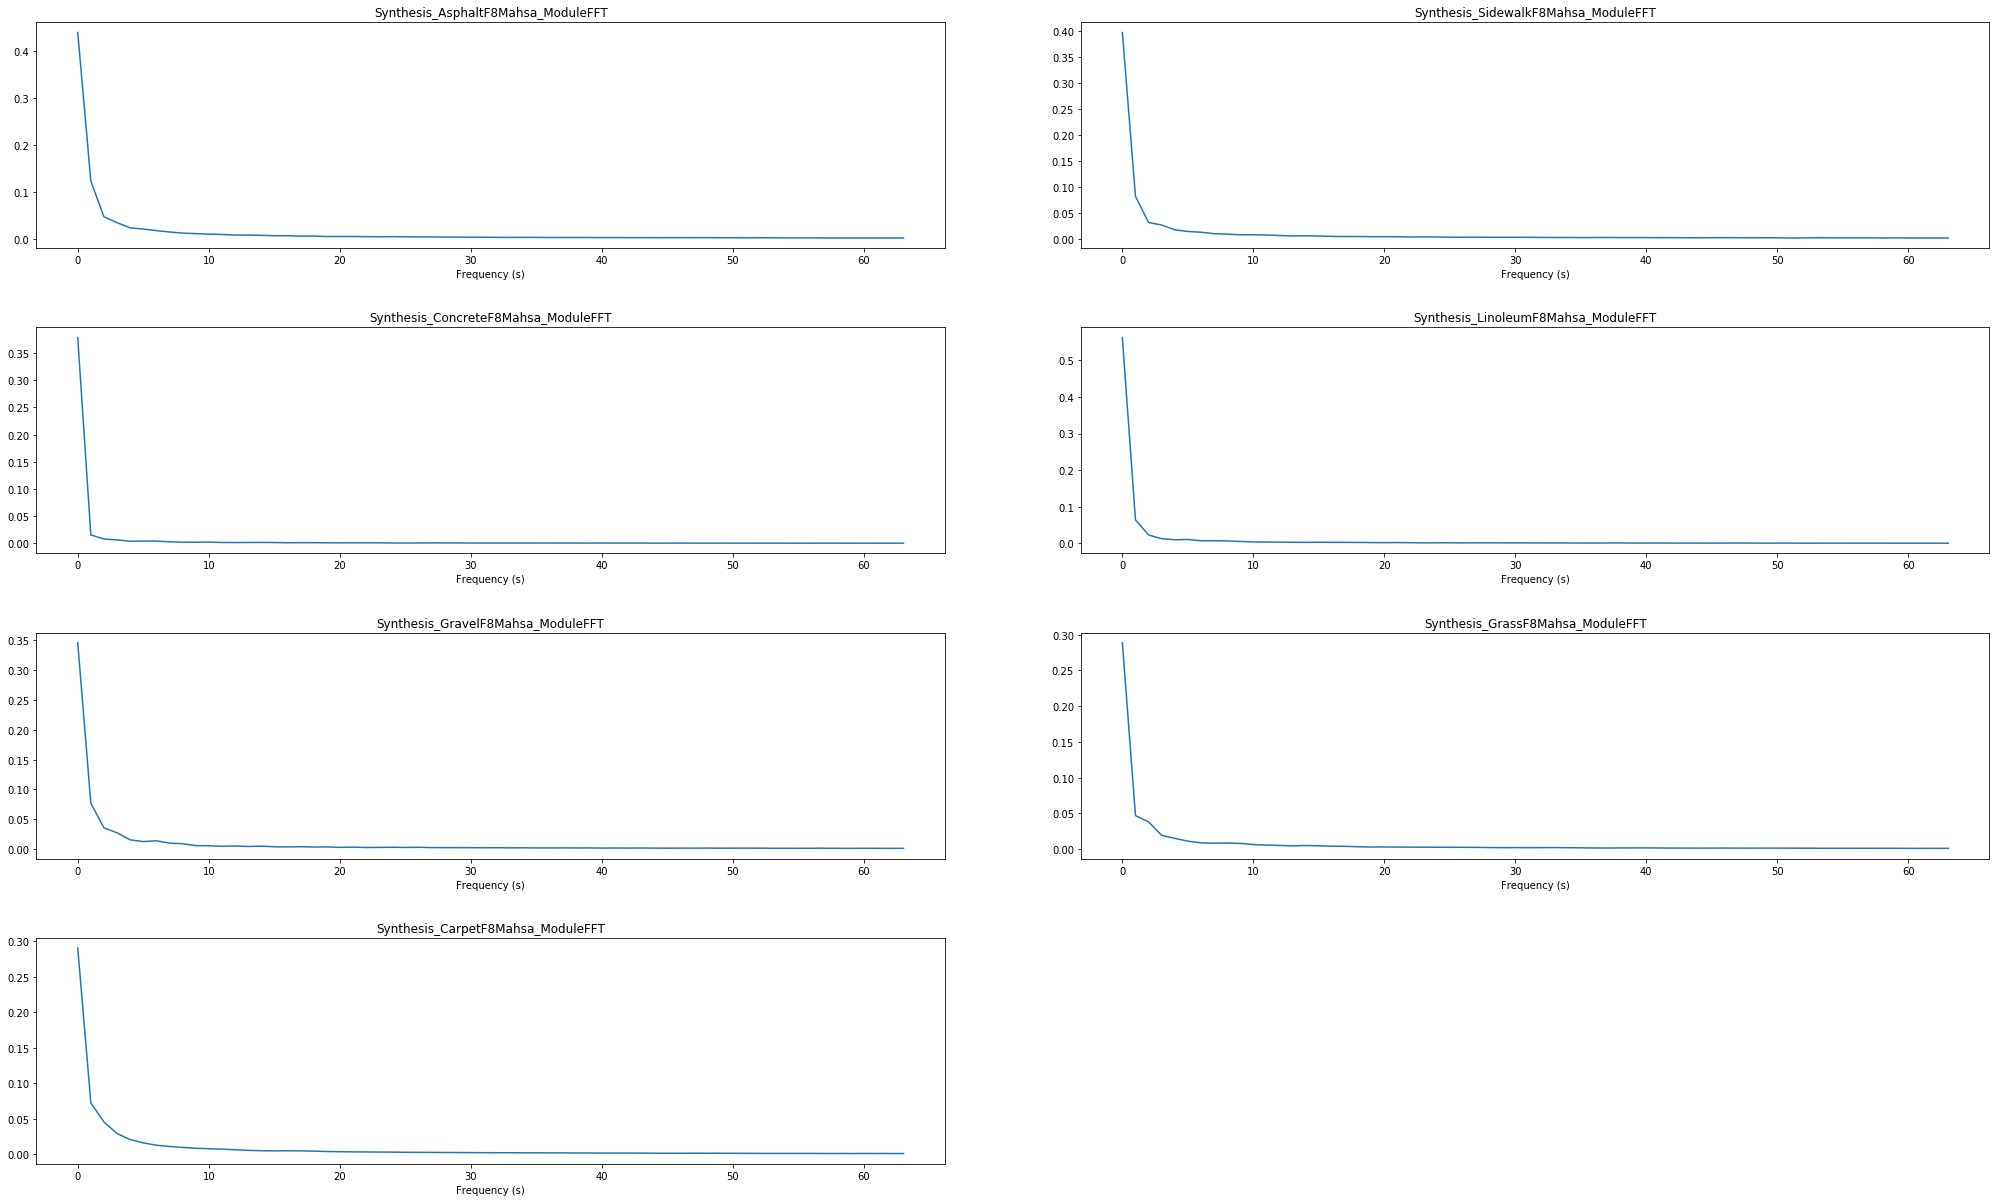

In [41]:
# Plot all the Frame FFTs for 0th window
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='Calc X Vel', windowed=True)

### Part (b) - PSD

In [42]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Frequencies depedent on dataset and device used
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_psd = np.zeros((n_bins, n_data_col))
        window_psd_log = np.zeros((n_bins, n_data_col))
        
        # Calculate PSD for each axes
        for i in range(n_data_col):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            
            # Calculate log10 of PSD, replacing points where PSD = 0 with 0 to avoid division by 0
            for j in range(len(window_psd[:, i])):
                if (window_psd[j, i] == 0):
                    window_psd_log[j, i] = 0
                else:
                    window_psd_log[j, i] = np.log10(window_psd[j, i])
            
        # Append freq column
        freq_col = np.transpose([np.resize(freq[:-1], n_bins)])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + 'PSD': dataset_psd})
    datasets_psd_log.update({label +'PSDLog': dataset_psd_log})

In [43]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd[dataset_labels[0]+'PSD'][0].shape))

Num PSD'd windowed datasets: 21
Num of PSD'd windows in first dataset: 60
Shape of PSD'd individual window: (64, 18)


<Figure size 432x288 with 0 Axes>

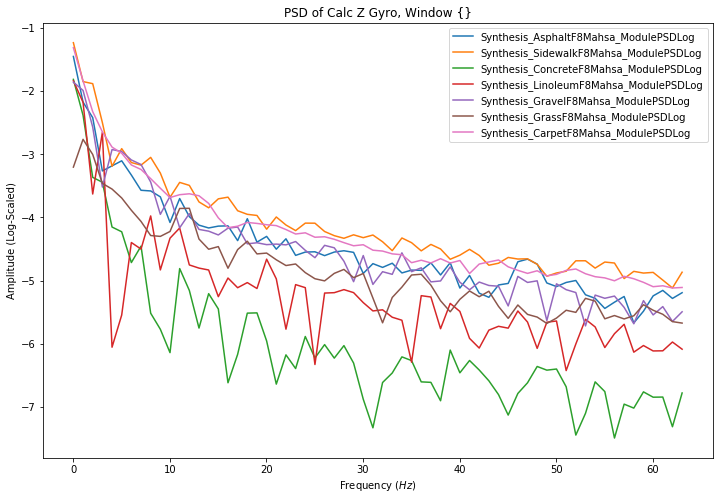

In [44]:
# Plot Z Accel of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Synthesis' in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=2, transform_name='PSD')

<Figure size 432x288 with 0 Axes>

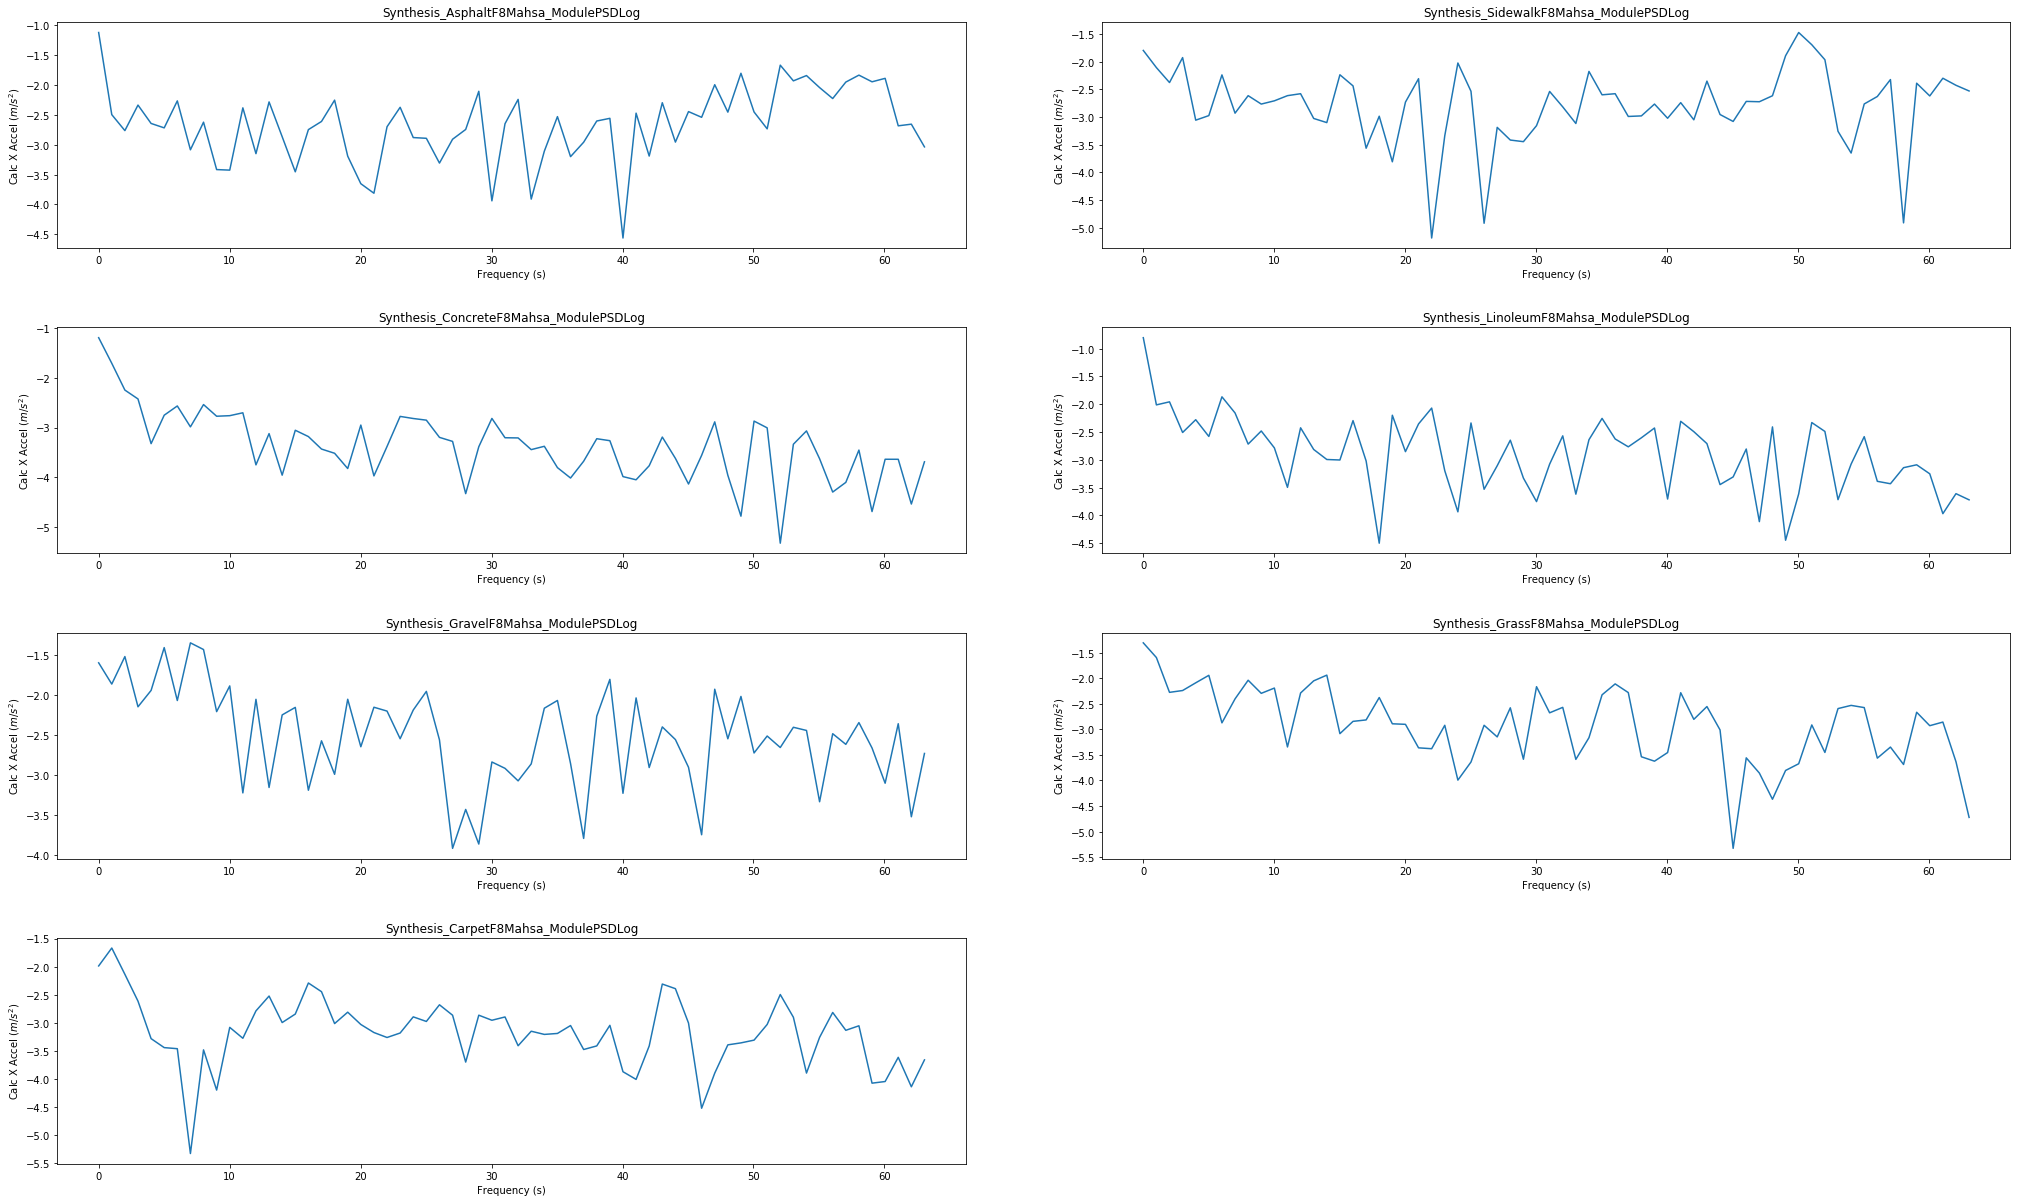

In [45]:
# Plot all PSDs of Z Accel for 0th window
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='Calc X Accel', windowed=True)

#### Data Structure:

`Labelled Terrain Dataset
-> Time Window
---> 2D NumPy Array
-----> Row = Transform Value for Frequency
-----> Col = Dirn | Frequency`

### Part (c) - 3D Visualization

In [46]:
'''Plot the set transforms in 3d'''
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific to FFT or PSD
    if transform_name == 'FFT':
        z_lim = (0, 1.6)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Normalized to Window Size)')
        
    elif transform_name == 'PSD':
        z_lim = (-10, -30)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    n_datasets = len(datasets_transformed)
    
    # Change y axis to corespond with terrain labels
    ax.set_ylim(0.5, n_datasets+0.5)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1.5))
    y_labels = [get_terrain_name(get_terrain_num(key)) for key in datasets_transformed.keys()]
    ax.set_yticklabels(y_labels)
    
    ax.set_xlabel('Frequency ($Hz$)')
    
    # Bar graph paremeters
    width = depth = 0.75
    
    # TODO: Sort by max amplitude
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        # To plot
        x = dataset[win_num][:, -1]
        y = [i+1]
        top = dataset[win_num][:, dirn]
        
        # Specific to transform
        bot = np.full(top.shape, z_lim[0])
        ax.bar3d(x, y, bot, width, depth, top, alpha=0.8)
        
        # TODO: Make this nicer
        ax.set_title(transform_name + ' of ' + get_columns(label)[dirn] + ', Window {}')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

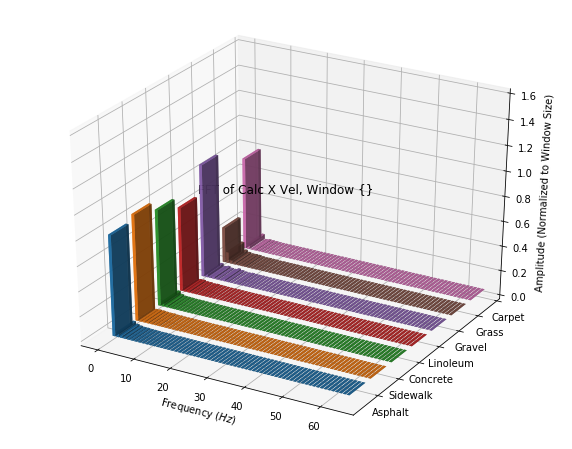

In [47]:
# Plot 3D Z Accel FFT of 0th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label}
plot_transforms_3d(ffts_to_plot, win_num=4, dirn=1, transform_name='FFT')

<Figure size 432x288 with 0 Axes>

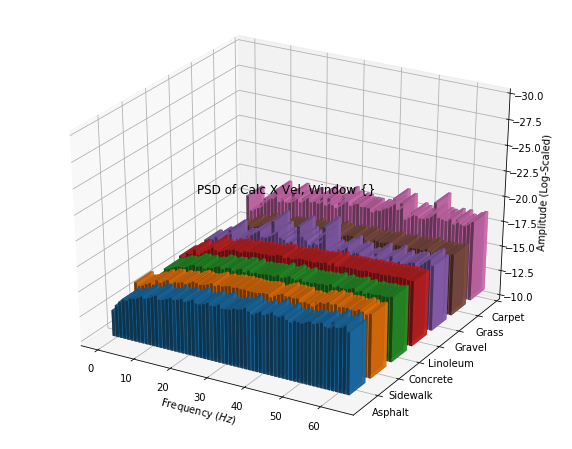

In [48]:
# Plot 3D Z Accel PSD of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label }
plot_transforms_3d(psds_to_plot, win_num=4, dirn=1, transform_name='PSD')

### Part (d) - Spectograms

In [49]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size):
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(get_columns(set_label)[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

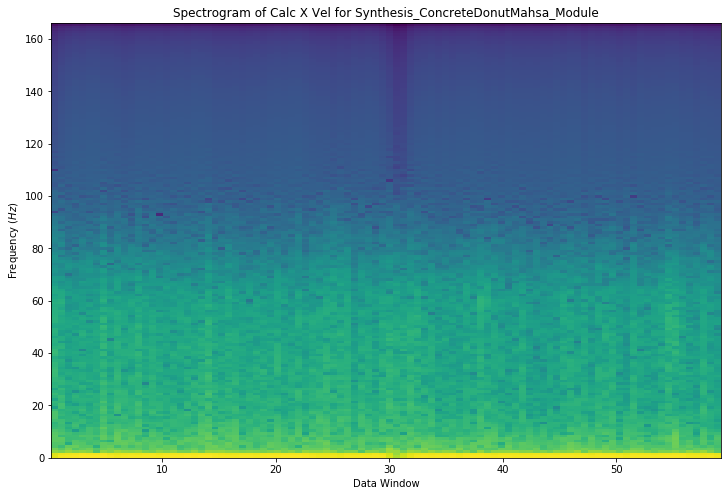

In [50]:
plot_spectogram(dataset_labels[0], dirn=1, size=get_window_size(dataset_labels[0]))

## Part 5 - Feature Extraction

#### Extract possibly relevant features (e.g. Mean, Min, Skew) from each data window

In [51]:
# Feature extraction functions

# For small float values
EPSILON = 0.00001

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Locations where array > 0, put -1 and 1 for rising/falling,
    # divide by total datapoints
    return len(np.nonzero(np.diff(array > 0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [52]:
'''Extract given features from everything in dataset'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        n_data_col = get_n_data_col(label)
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:n_data_col]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window
                    
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('PSD', ''): directions})
    
    return datasets_feat

In [53]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name, placement_name, ylim=None, xlim=None):
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
        
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(placement_name + ' ' + dirn)
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [54]:
# Time domain feature functions and names
time_features = {'Mean': np.mean, 'Std Dev': np.std,  'L2 Norm': l2norm, 'Autocorrelation': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'Root Mean Squared': rms, 'Zero Crossing Rate': zcr, 
                 'Skew': stats.skew, 'Excess Kurtosis': stats.kurtosis} 

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

In [55]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['Calc X Accel'].shape))

Num datasets: 21
Num directions: 17
Shape of first dataset first direction: (60, 10)


<Figure size 432x288 with 0 Axes>

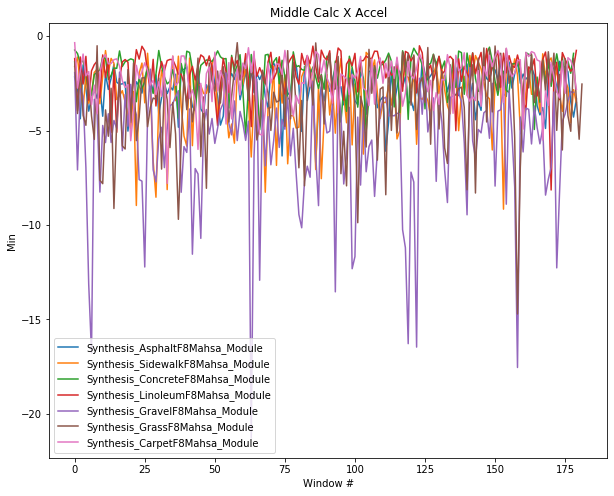

In [56]:
# Plot Min of frame Z Accel
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Synthesis' in label in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Calc X Accel', feat_name='Min', placement_name='Middle')

### Part (b) - Frequency Domain Features

In [57]:
# Frequency domain feature functions and names
freq_features = {'Mean Square Frequency': msf, 'Root Mean Square Frequency': rmsf, 'Frequency Center': fc, 
                 'Variance Frequency': vf, 'Root Variance Frequency': rvf}

# Create array of features of each window for each dataset and direction
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

In [58]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['Calc X Vel'].shape))

Num datasets: 21
Num directions: 17
Shape of one direction: (60, 5)


<Figure size 432x288 with 0 Axes>

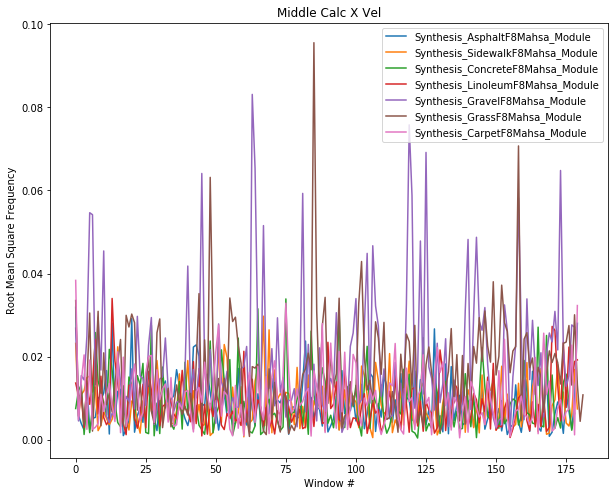

In [59]:
# Plot RMSF of Y Accel
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Calc X Vel', feat_name='Root Mean Square Frequency', placement_name='Middle')

#### Data Structure

`Terrain Dataset Dictionary
-> Direction Dictionary 
---> Pandas Array
-----> Row = Window #
-----> Col = Extracted Feature`

## Part 6 - Standardization, Columning, and Combining Datasets

**Since Z Gyro data is often cutoff out of range on old datasets, possible to get PSD of zero which results in NaN values**

This is likely the cause of some of the errors below

In [60]:
# Convert transformed data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

In [61]:
# Run to convert transformed data back to Numpy
#datasets_fft = pd_to_np(datasets_fft, windowed=True)
#datasets_psd_log = pd_to_np(datasets_psd_log, windowed=True)

In [62]:
# Add time and frequency features together
datasets_feat = {}

for label, dataset in datasets_feat_time.items():
    dataset_feat = {}
    
    for dirn_label, dirn_df in dataset.items():
        new_df = dirn_df.join(datasets_feat_freq[label][dirn_label], how='outer')
        dataset_feat.update({dirn_label: new_df})
    
    datasets_feat.update({label: dataset_feat})

In [63]:
# Confirm formatting
datasets_feat[dataset_labels[0]]['Calc X Accel'].head()

,Mean,Std Dev,L2 Norm,Autocorrelation,Max,Min,Root Mean Squared,Zero Crossing Rate,Skew,Excess Kurtosis,Mean Square Frequency,Root Mean Square Frequency,Frequency Center,Variance Frequency,Root Variance Frequency
0,0.680425,0.724034,18.131151,328.738625,4.596230,-2.214728,0.993581,0.060060,0.280635,6.668366,0.379848,0.616318,26.630054,-708.779904,0.616318
1,0.179359,0.435690,8.597937,73.924513,1.850748,-1.208062,0.471164,0.120120,0.415202,1.056503,0.044750,0.211541,14.994539,-224.791456,0.211541
2,0.110576,0.469800,8.807305,77.568627,2.088983,-1.874745,0.482637,0.132132,0.456350,2.377257,0.051639,0.227242,15.538215,-241.384483,0.227242
3,-0.088710,0.394220,7.373730,54.371888,1.058026,-1.508710,0.404078,0.138138,-0.447629,1.048979,0.042330,0.205741,15.504022,-240.332362,0.205741
4,-0.018291,0.699489,12.768848,163.043478,4.836787,-1.807007,0.699729,0.123123,2.552536,12.028643,0.185175,0.430320,21.727850,-471.914285,0.430320


### Part (a) - Standardization

#### Standardize each feature to mean 0 and standard deviation 1. This makes feature selection and classification easier.

In [64]:
'''Normalize already featured datasets'''
def normalize_datasets(datasets, windowed=False):
    # Normalization function
    from sklearn.preprocessing import scale
    
    datasets_norm = {}
    
    # Go through windowed data (transforms) or dictionary data (features)
    for label, dataset in datasets.items():
        if windowed:
            dataset_norm = []
            for window_df in dataset:
                window_df = window_df.dropna()
                dataset_norm.append(window_df.apply(scale))
        else:
            dataset_norm = {}
            for dirn_label, dirn_df in dataset.items():
                dirn_df = dirn_df.dropna()
                dataset_norm.update({dirn_label: dirn_df.apply(sklearn.preprocessing.scale)})
        
        datasets_norm.update({label: dataset_norm})
    
    return datasets_norm

In [65]:
# So we can remove infinites
pd.set_option('use_inf_as_na', True)

datasets_feat_norm = normalize_datasets(datasets_feat)
datasets_fft_norm = normalize_datasets(datasets_fft, windowed=True)
datasets_psd_norm = normalize_datasets(datasets_psd_log, windowed=True)

In [66]:
datasets_feat_norm[dataset_labels[0]]['Calc X Accel'].head()

,Mean,Std Dev,L2 Norm,Autocorrelation,Max,Min,Root Mean Squared,Zero Crossing Rate,Skew,Excess Kurtosis,Mean Square Frequency,Root Mean Square Frequency,Frequency Center,Variance Frequency,Root Variance Frequency
0,3.894363,1.778198,3.027773,3.542383,2.716084,-0.303671,3.027773,-1.490282,0.419100,0.927816,3.167178,2.660999,1.967928,-2.160082,2.660999
1,1.013843,-0.316512,-0.193879,-0.284619,0.035479,0.698918,-0.193879,0.474925,0.563290,-0.662458,-0.480490,-0.429951,-0.183717,0.305566,-0.429951
2,0.618423,-0.068718,-0.123125,-0.229889,0.268084,0.034934,-0.123125,0.867967,0.607381,-0.288186,-0.405498,-0.310056,-0.083180,0.221034,-0.310056
3,-0.527234,-0.617776,-0.607587,-0.578276,-0.738512,0.399487,-0.607587,1.064487,-0.361248,-0.664590,-0.506833,-0.474236,-0.089503,0.226394,-0.474236
4,-0.122405,1.599891,1.215638,1.053841,2.950957,0.102399,1.215638,0.573185,2.853480,2.446796,1.048092,1.240683,1.061410,-0.953385,1.240683


<Figure size 432x288 with 0 Axes>

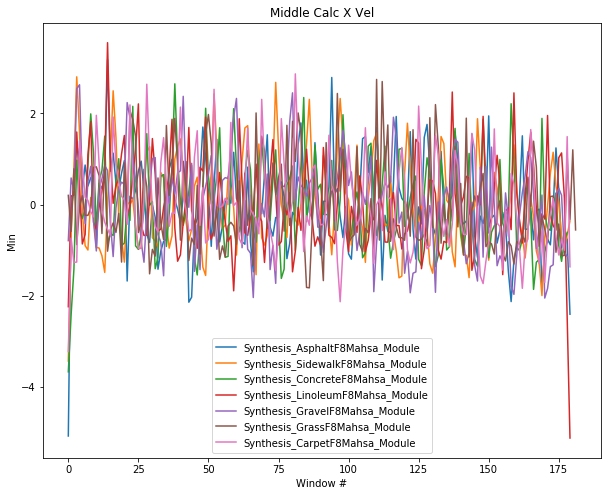

In [67]:
# Plot normalized features
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_norm.items() if 'Synthesis' in label in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Calc X Vel', feat_name='Min', placement_name='Middle')

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

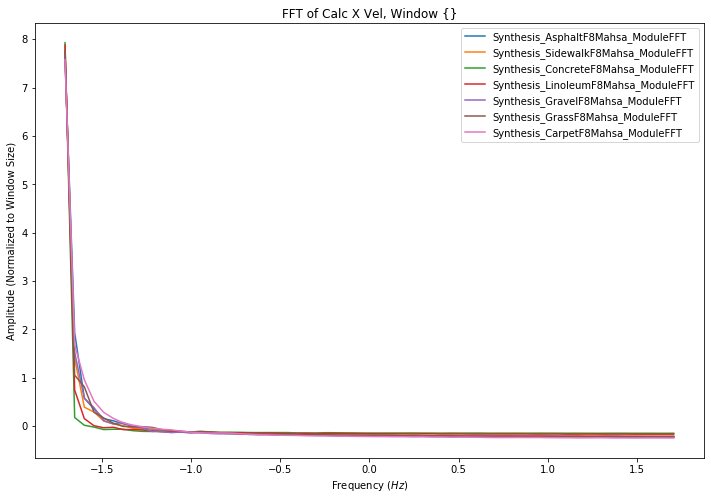

In [68]:
# Plot normalized fft
ffts_to_plot = {label: dataset for label, dataset in datasets_fft_norm.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(pd_to_np(ffts_to_plot, windowed=True), dirn=1, win_num=0, transform_name='FFT')

### Part (b) - Columning Data

#### Combine IMU data from each direction into single dataframes with columns for each feature in each direction

#### Part (i) - Extracted Featured Data

In [69]:
'''Append a tag to the end of every column name of a dataframe'''
def append_all_columns(columns, append_tag):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_tag)
    
    return new_columns

In [70]:
'''Combined directions of a featured dataset'''
def combine_columns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            df_copy = pd.DataFrame(dirn_df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_copy.columns = append_all_columns(dirn_df.columns, get_placement(label))
            
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [71]:
# Take frame data and combine directions
datasets_feat_columned = combine_columns(datasets_feat_norm)

# Confirm formatting
datasets_feat_columned[dataset_labels[0]].head()

,Mean Calc X Accel Synthesis,Std Dev Calc X Accel Synthesis,L2 Norm Calc X Accel Synthesis,Autocorrelation Calc X Accel Synthesis,Max Calc X Accel Synthesis,Min Calc X Accel Synthesis,Root Mean Squared Calc X Accel Synthesis,Zero Crossing Rate Calc X Accel Synthesis,Skew Calc X Accel Synthesis,Excess Kurtosis Calc X Accel Synthesis,...,Min Right Z Gyro Synthesis,Root Mean Squared Right Z Gyro Synthesis,Zero Crossing Rate Right Z Gyro Synthesis,Skew Right Z Gyro Synthesis,Excess Kurtosis Right Z Gyro Synthesis,Mean Square Frequency Right Z Gyro Synthesis,Root Mean Square Frequency Right Z Gyro Synthesis,Frequency Center Right Z Gyro Synthesis,Variance Frequency Right Z Gyro Synthesis,Root Variance Frequency Right Z Gyro Synthesis
0,3.894363,1.778198,3.027773,3.542383,2.716084,-0.303671,3.027773,-1.490282,0.419100,0.927816,...,-0.231372,-0.358857,-0.185695,0.664847,-0.611102,2.278265,2.448311,0.274851,0.078802,2.448311
1,1.013843,-0.316512,-0.193879,-0.284619,0.035479,0.698918,-0.193879,0.474925,0.563290,-0.662458,...,-0.892981,0.829635,-0.185695,0.346950,-0.781463,-0.403126,-0.487567,-0.856585,0.567476,-0.487567
2,0.618423,-0.068718,-0.123125,-0.229889,0.268084,0.034934,-0.123125,0.867967,0.607381,-0.288186,...,-1.364492,1.360570,-0.185695,0.199874,-0.843535,-0.402845,-0.486544,-0.906600,0.574183,-0.486544
3,-0.527234,-0.617776,-0.607587,-0.578276,-0.738512,0.399487,-0.607587,1.064487,-0.361248,-0.664590,...,-1.445854,1.635411,-0.185695,0.125345,-0.558159,-0.445880,-0.669994,-0.898277,0.573091,-0.669994
4,-0.122405,1.599891,1.215638,1.053841,2.950957,0.102399,1.215638,0.573185,2.853480,2.446796,...,-1.333675,1.500356,-0.185695,0.975282,0.361906,-0.156450,0.119588,-0.136426,0.329784,0.119588


#### Part (ii) - Transformed Data

In [72]:
'''Combined direction columns for transformed data'''
def combine_transform_columns(datasets):
    combined_datasets = {}
    
    for label, dataset in datasets.items():
        combined_windows = []
        
        for window in dataset:
            window_as_row = pd.DataFrame()
            
            # Turn each window 2D dataframe into a single row dataframe
            for row in window.iterrows():
                for data_column in get_columns(label)[:get_n_data_col(label)]:
                    combined_column_name = get_transform(label) + ' {} Hz '.format(round(row[1]['Frequency']))
                    combined_column_name +=  data_column + ' ' + get_placement(label)
                    window_as_row.insert(0, combined_column_name, [row[1][data_column]])
            
            combined_windows.append(window_as_row)
        
        # Combine all the single row dataframes into one dataframe
        combined_datasets.update({label: pd.concat(combined_windows, ignore_index=True)})
    
    return combined_datasets

In [73]:
datasets_fft_columned = combine_transform_columns(datasets_fft)

In [74]:
datasets_psd_log_columned = combine_transform_columns(datasets_psd_log)

In [75]:
# Check FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT']

,FFT 63.0 Hz Right Z Gyro Synthesis,FFT 63.0 Hz Right Y Gyro Synthesis,FFT 63.0 Hz Right X Gyro Synthesis,FFT 63.0 Hz Right XY Accel Synthesis,FFT 63.0 Hz Right Z Accel Synthesis,FFT 63.0 Hz Right Y Accel Synthesis,FFT 63.0 Hz Right X Accel Synthesis,FFT 63.0 Hz Left Z Gyro Synthesis,FFT 63.0 Hz Left Y Gyro Synthesis,FFT 63.0 Hz Left X Gyro Synthesis,...,FFT 0.0 Hz Left Z Gyro Synthesis,FFT 0.0 Hz Left Y Gyro Synthesis,FFT 0.0 Hz Left X Gyro Synthesis,FFT 0.0 Hz Left XY Accel Synthesis,FFT 0.0 Hz Left Z Accel Synthesis,FFT 0.0 Hz Left Y Accel Synthesis,FFT 0.0 Hz Left X Accel Synthesis,FFT 0.0 Hz Calc Z Gyro Synthesis,FFT 0.0 Hz Calc X Vel Synthesis,FFT 0.0 Hz Calc X Accel Synthesis
0,0.006068,0.000799,0.001134,0.006536,0.006458,0.047178,0.022067,0.004365,0.002008,0.000420,...,1.048671,0.368408,0.155242,9.507535,0.528730,6.998796,5.670221,0.350500,0.400488,0.680425
1,0.001021,0.001925,0.001915,0.014137,0.014846,0.037668,0.033946,0.001454,0.002015,0.001766,...,2.073095,0.361963,0.457949,10.095409,0.452736,4.291642,7.343111,0.589247,0.764767,0.179359
2,0.000836,0.002495,0.001719,0.004795,0.016354,0.048265,0.023518,0.000988,0.001165,0.004054,...,2.677896,0.217143,0.100495,9.843836,0.414762,7.159990,1.172795,0.485485,0.916206,0.110576
3,0.000115,0.003464,0.000370,0.005332,0.022029,0.041343,0.010623,0.001481,0.001687,0.004100,...,2.506799,0.719106,0.008414,9.582898,0.119022,6.986162,1.247444,0.754871,0.935772,0.088710
4,0.001406,0.002258,0.003633,0.005800,0.022313,0.025849,0.052147,0.000140,0.002816,0.002956,...,2.550840,0.187933,0.491600,10.170395,0.376676,4.370143,6.315990,0.739853,0.944860,0.018291
5,0.001898,0.001044,0.002903,0.005109,0.018030,0.015777,0.047980,0.002192,0.003193,0.000747,...,1.929493,0.018273,0.671618,9.383827,0.328469,2.253200,7.680593,0.763000,0.767580,0.291906
6,0.001458,0.000742,0.003196,0.014112,0.017110,0.025614,0.048908,0.000885,0.000641,0.002348,...,1.741439,0.634217,0.069059,9.674646,0.732464,8.300632,0.777065,0.616318,0.673967,0.047627
7,0.001621,0.001431,0.002811,0.010416,0.023059,0.022617,0.046331,0.001188,0.003629,0.001812,...,2.156869,0.057075,0.444609,10.230930,0.418589,2.574879,7.978681,0.507741,0.768289,0.144362
8,0.000791,0.000717,0.004264,0.009554,0.010301,0.014347,0.058016,0.000455,0.003775,0.002338,...,2.508241,0.141104,0.291717,9.554785,0.224314,4.079319,5.738078,0.527697,0.877132,0.097311
9,0.000281,0.001956,0.005418,0.004889,0.004438,0.015870,0.053835,0.002152,0.000304,0.003793,...,2.009171,0.869566,0.222794,9.808438,0.314213,7.874485,2.451633,0.922715,0.832611,0.126033


In [76]:
# Check PSD data
datasets_psd_log_columned[dataset_labels[0] + 'PSDLog']

,PSD 63.0 Hz Right Z Gyro Synthesis,PSD 63.0 Hz Right Y Gyro Synthesis,PSD 63.0 Hz Right X Gyro Synthesis,PSD 63.0 Hz Right XY Accel Synthesis,PSD 63.0 Hz Right Z Accel Synthesis,PSD 63.0 Hz Right Y Accel Synthesis,PSD 63.0 Hz Right X Accel Synthesis,PSD 63.0 Hz Left Z Gyro Synthesis,PSD 63.0 Hz Left Y Gyro Synthesis,PSD 63.0 Hz Left X Gyro Synthesis,...,PSD 0.0 Hz Left Z Gyro Synthesis,PSD 0.0 Hz Left Y Gyro Synthesis,PSD 0.0 Hz Left X Gyro Synthesis,PSD 0.0 Hz Left XY Accel Synthesis,PSD 0.0 Hz Left Z Accel Synthesis,PSD 0.0 Hz Left Y Accel Synthesis,PSD 0.0 Hz Left X Accel Synthesis,PSD 0.0 Hz Calc Z Gyro Synthesis,PSD 0.0 Hz Calc X Vel Synthesis,PSD 0.0 Hz Calc X Accel Synthesis
0,-4.134637,-5.734164,-5.612237,-5.825978,-4.295850,-2.420318,-3.103393,-4.464008,-4.995829,-6.073046,...,-0.707667,-1.433344,-2.140587,-2.369590,-3.105114,0.252863,0.525702,-1.826913,-1.583090,-2.451348
1,-5.715454,-5.271504,-4.960816,-3.653689,-4.344799,-2.512841,-2.770442,-5.273051,-4.852028,-5.220514,...,-1.765381,-1.489169,-1.460839,-1.707029,-1.236544,1.085859,0.803714,-2.210780,-2.457790,-1.283799
2,-5.764375,-4.925846,-5.232590,-3.816787,-3.756210,-2.336124,-3.092363,-5.728730,-5.635826,-4.504411,...,-2.027999,-2.327758,-1.065439,-1.100090,-1.738077,0.824390,1.380798,-1.769442,-2.468112,-1.138459
3,-7.445357,-4.684048,-6.007915,-4.620018,-2.760915,-2.337826,-3.147154,-5.407316,-5.361776,-4.436538,...,-1.858751,-1.321383,-0.879242,-1.132694,-1.307062,0.719097,1.382309,-1.489884,-3.318929,-1.359251
4,-5.426467,-5.056353,-4.659280,-3.796010,-3.225466,-2.468428,-2.295175,-6.440781,-4.448481,-4.774643,...,-1.820904,-0.867856,-1.263764,-1.744468,-0.914103,1.288557,1.096208,-2.028820,-3.097857,-1.385237
5,-5.161984,-5.658659,-4.571744,-4.503569,-3.855827,-3.570909,-2.424232,-5.027627,-4.768994,-7.045965,...,-1.800501,-1.059567,-1.306239,-1.792911,-1.498157,1.131629,0.308058,-1.922931,-4.118952,-0.891982
6,-5.426398,-5.808936,-4.887918,-4.115584,-4.087825,-3.051574,-2.312532,-5.826518,-5.793590,-4.812193,...,-1.551268,-1.856772,-1.241624,-1.615353,-1.809155,0.040336,1.207616,-2.294171,-2.552931,-1.038758
7,-5.254202,-5.534265,-4.528942,-4.081808,-2.898965,-2.909167,-2.354677,-6.051680,-5.266426,-5.469698,...,-1.951820,-1.246752,-2.072187,-1.997174,-1.063655,1.305317,0.578890,-2.462590,-3.116134,-1.062854
8,-6.013270,-5.875998,-4.370353,-4.050115,-3.802154,-3.620292,-2.246076,-5.926713,-4.847105,-5.071197,...,-2.463734,-1.028846,-2.050875,-1.283571,-1.206930,1.299266,0.977454,-1.952925,-3.529445,-1.225623
9,-6.866918,-5.061421,-4.186490,-5.471436,-3.946438,-3.162681,-2.332966,-5.137223,-8.516121,-4.499579,...,-1.492527,-1.470198,-0.834144,-1.162369,-1.878104,0.384790,1.229179,-3.542846,-2.483837,-1.479072


### Part (c) - Adding Labels

Create a new column containg the an integer label for each terrain.

In [77]:
'Add labels to a dataset'
def insert_labels(datasets):
    # Returns new datasets
    datasets_copy = {}
    
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        terrain_num = get_terrain_num(label)
        labels = [terrain_num for _ in range(len(dataset))]
        
        dataset_copy = dataset.copy()
        dataset_copy.insert(0, 'Label', labels)
        
        datasets_copy.update({label: dataset_copy})
    
    return datasets_copy

In [78]:
# Add labels
datasets_feat_columned = insert_labels(datasets_feat_columned)
datasets_fft_columned = insert_labels(datasets_fft_columned)
datasets_psd_log_columned = insert_labels(datasets_psd_log_columned)

In [79]:
# Check labelled feature data
datasets_feat_columned[dataset_labels[0]].head()

,Label,Mean Calc X Accel Synthesis,Std Dev Calc X Accel Synthesis,L2 Norm Calc X Accel Synthesis,Autocorrelation Calc X Accel Synthesis,Max Calc X Accel Synthesis,Min Calc X Accel Synthesis,Root Mean Squared Calc X Accel Synthesis,Zero Crossing Rate Calc X Accel Synthesis,Skew Calc X Accel Synthesis,...,Min Right Z Gyro Synthesis,Root Mean Squared Right Z Gyro Synthesis,Zero Crossing Rate Right Z Gyro Synthesis,Skew Right Z Gyro Synthesis,Excess Kurtosis Right Z Gyro Synthesis,Mean Square Frequency Right Z Gyro Synthesis,Root Mean Square Frequency Right Z Gyro Synthesis,Frequency Center Right Z Gyro Synthesis,Variance Frequency Right Z Gyro Synthesis,Root Variance Frequency Right Z Gyro Synthesis
0,0,3.894363,1.778198,3.027773,3.542383,2.716084,-0.303671,3.027773,-1.490282,0.419100,...,-0.231372,-0.358857,-0.185695,0.664847,-0.611102,2.278265,2.448311,0.274851,0.078802,2.448311
1,0,1.013843,-0.316512,-0.193879,-0.284619,0.035479,0.698918,-0.193879,0.474925,0.563290,...,-0.892981,0.829635,-0.185695,0.346950,-0.781463,-0.403126,-0.487567,-0.856585,0.567476,-0.487567
2,0,0.618423,-0.068718,-0.123125,-0.229889,0.268084,0.034934,-0.123125,0.867967,0.607381,...,-1.364492,1.360570,-0.185695,0.199874,-0.843535,-0.402845,-0.486544,-0.906600,0.574183,-0.486544
3,0,-0.527234,-0.617776,-0.607587,-0.578276,-0.738512,0.399487,-0.607587,1.064487,-0.361248,...,-1.445854,1.635411,-0.185695,0.125345,-0.558159,-0.445880,-0.669994,-0.898277,0.573091,-0.669994
4,0,-0.122405,1.599891,1.215638,1.053841,2.950957,0.102399,1.215638,0.573185,2.853480,...,-1.333675,1.500356,-0.185695,0.975282,0.361906,-0.156450,0.119588,-0.136426,0.329784,0.119588


In [80]:
# Check labelled FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT'].head()

,Label,FFT 63.0 Hz Right Z Gyro Synthesis,FFT 63.0 Hz Right Y Gyro Synthesis,FFT 63.0 Hz Right X Gyro Synthesis,FFT 63.0 Hz Right XY Accel Synthesis,FFT 63.0 Hz Right Z Accel Synthesis,FFT 63.0 Hz Right Y Accel Synthesis,FFT 63.0 Hz Right X Accel Synthesis,FFT 63.0 Hz Left Z Gyro Synthesis,FFT 63.0 Hz Left Y Gyro Synthesis,...,FFT 0.0 Hz Left Z Gyro Synthesis,FFT 0.0 Hz Left Y Gyro Synthesis,FFT 0.0 Hz Left X Gyro Synthesis,FFT 0.0 Hz Left XY Accel Synthesis,FFT 0.0 Hz Left Z Accel Synthesis,FFT 0.0 Hz Left Y Accel Synthesis,FFT 0.0 Hz Left X Accel Synthesis,FFT 0.0 Hz Calc Z Gyro Synthesis,FFT 0.0 Hz Calc X Vel Synthesis,FFT 0.0 Hz Calc X Accel Synthesis
0,0,0.006068,0.000799,0.001134,0.006536,0.006458,0.047178,0.022067,0.004365,0.002008,...,1.048671,0.368408,0.155242,9.507535,0.528730,6.998796,5.670221,0.350500,0.400488,0.680425
1,0,0.001021,0.001925,0.001915,0.014137,0.014846,0.037668,0.033946,0.001454,0.002015,...,2.073095,0.361963,0.457949,10.095409,0.452736,4.291642,7.343111,0.589247,0.764767,0.179359
2,0,0.000836,0.002495,0.001719,0.004795,0.016354,0.048265,0.023518,0.000988,0.001165,...,2.677896,0.217143,0.100495,9.843836,0.414762,7.159990,1.172795,0.485485,0.916206,0.110576
3,0,0.000115,0.003464,0.000370,0.005332,0.022029,0.041343,0.010623,0.001481,0.001687,...,2.506799,0.719106,0.008414,9.582898,0.119022,6.986162,1.247444,0.754871,0.935772,0.088710
4,0,0.001406,0.002258,0.003633,0.005800,0.022313,0.025849,0.052147,0.000140,0.002816,...,2.550840,0.187933,0.491600,10.170395,0.376676,4.370143,6.315990,0.739853,0.944860,0.018291


### Part (d) - Combining Datasets

Combine data from every dataset into rows in a single dataframe

In [81]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [82]:
# Combine all data individually
# TODO: Combine each mounting source of a single dataset into a single dataframe so we can select across all
def separate_and_combine(datasets_columned, csv_tag):
    datasets_separated = {}
    
    # Separate according to mounting location
    for placement in placements:
        datasets = {label: dataset for label, dataset in datasets_columned.items() if placement in label}
        
        # Update if not empty
        if bool(datasets): 
            datasets_separated.update({placement: datasets})
    
    # Combine each mounting into a single combined dataframe and drop NaN values, export to csv
    for placement, datasets in datasets_separated.items():
        # NaN values usually come from cutoff range of Z gyro, so drop the column
        datasets_separated.update({placement: combine_datasets(datasets).dropna(axis='columns')})
        
        # Export to a csv file
        csv_filename = 'processed_data/' + placement + '_' + csv_tag + '.csv'
        datasets_separated[placement].to_csv(csv_filename, index=False)
                        
    # Return dictionary of each mounting location
    return datasets_separated

In [83]:
# Convert features
feat_combined = separate_and_combine(datasets_feat_columned, csv_tag='Features_Filt_Mahsa')

feat_combined['Synthesis'].tail()

,Label,Mean Calc X Accel Synthesis,Std Dev Calc X Accel Synthesis,L2 Norm Calc X Accel Synthesis,Autocorrelation Calc X Accel Synthesis,Max Calc X Accel Synthesis,Min Calc X Accel Synthesis,Root Mean Squared Calc X Accel Synthesis,Zero Crossing Rate Calc X Accel Synthesis,Skew Calc X Accel Synthesis,...,Min Right Z Gyro Synthesis,Root Mean Squared Right Z Gyro Synthesis,Zero Crossing Rate Right Z Gyro Synthesis,Skew Right Z Gyro Synthesis,Excess Kurtosis Right Z Gyro Synthesis,Mean Square Frequency Right Z Gyro Synthesis,Root Mean Square Frequency Right Z Gyro Synthesis,Frequency Center Right Z Gyro Synthesis,Variance Frequency Right Z Gyro Synthesis,Root Variance Frequency Right Z Gyro Synthesis
2284,4,-0.200865,2.036835,1.986321,1.908995,1.745887,-1.908300,1.986321,2.621010,0.374518,...,0.629201,-0.907116,-0.224982,2.401628,1.354629,0.326125,0.812414,1.085081,-0.724494,0.812414
2285,4,-3.149334,-0.439548,0.027641,-0.155083,-0.984385,-0.627062,0.027641,-3.033777,-2.870903,...,1.811831,-2.430871,1.870904,-3.452284,5.116383,-0.186077,0.079647,2.092820,-2.216934,0.079647
2286,4,-0.383236,-1.585848,-1.587815,-0.849214,-1.097832,1.098964,-1.587815,0.283698,-1.593069,...,2.326925,-2.481682,-0.224982,0.684509,-0.905423,-0.490008,-0.900724,-0.573584,0.537852,-0.900724
2287,4,0.397801,-0.230085,-0.265227,-0.348562,-0.631311,0.446189,-0.265227,-1.752026,-0.113916,...,1.916061,-2.409878,6.761304,-0.747771,1.171221,0.708028,1.211862,0.685266,-0.283611,1.211862
2288,4,0.031978,-1.246498,-1.285286,-0.788583,-0.945018,0.935087,-1.285286,-1.224245,-0.039373,...,2.216454,-2.512991,2.569532,-1.107179,1.350424,-0.383894,-0.383011,0.771750,-0.373513,-0.383011


In [84]:
# Convert features
fft_combined = separate_and_combine(datasets_fft_columned, csv_tag='FFTs_Filt_Mahsa')

fft_combined['Synthesis'].tail()

,Label,FFT 63.0 Hz Right Z Gyro Synthesis,FFT 63.0 Hz Right Y Gyro Synthesis,FFT 63.0 Hz Right X Gyro Synthesis,FFT 63.0 Hz Right XY Accel Synthesis,FFT 63.0 Hz Right Z Accel Synthesis,FFT 63.0 Hz Right Y Accel Synthesis,FFT 63.0 Hz Right X Accel Synthesis,FFT 63.0 Hz Left Z Gyro Synthesis,FFT 63.0 Hz Left Y Gyro Synthesis,...,FFT 0.0 Hz Left Z Gyro Synthesis,FFT 0.0 Hz Left Y Gyro Synthesis,FFT 0.0 Hz Left X Gyro Synthesis,FFT 0.0 Hz Left XY Accel Synthesis,FFT 0.0 Hz Left Z Accel Synthesis,FFT 0.0 Hz Left Y Accel Synthesis,FFT 0.0 Hz Left X Accel Synthesis,FFT 0.0 Hz Calc Z Gyro Synthesis,FFT 0.0 Hz Calc X Vel Synthesis,FFT 0.0 Hz Calc X Accel Synthesis
2284,4,0.003630,0.001860,0.000933,0.056073,0.055074,0.046830,0.043307,0.001153,0.002174,...,3.523264,0.402254,0.016910,10.047909,1.949181,4.513651,0.355665,0.989021,0.782217,0.049360
2285,4,0.001638,0.002121,0.000134,0.019920,0.012119,0.014738,0.002177,0.008650,0.002253,...,1.146348,0.389609,0.264453,10.219312,0.402267,8.934720,3.917656,0.432151,0.225813,0.723356
2286,4,0.000179,0.000825,0.000234,0.002650,0.009556,0.004480,0.002204,0.001174,0.000579,...,0.129872,0.059158,0.019209,9.959313,0.076916,9.602992,2.617701,0.049588,0.025419,0.091049
2287,4,0.000216,0.000826,0.001025,0.008924,0.011555,0.010483,0.002032,0.001459,0.000803,...,0.263411,0.153845,0.078377,10.128986,0.234734,8.439221,5.473153,0.136637,0.042181,0.087490
2288,4,0.000238,0.000080,0.000587,0.007123,0.017337,0.007279,0.002484,0.000324,0.000519,...,0.043798,0.007719,0.017289,10.146268,0.348072,8.159685,5.999961,0.035488,0.003693,0.003866


In [85]:
# Convert features
psd_log_combined = separate_and_combine(datasets_psd_log_columned, csv_tag='PSDLogs_Filt_Mahsa')

psd_log_combined['Synthesis'].tail()

,Label,PSD 63.0 Hz Right Z Gyro Synthesis,PSD 63.0 Hz Right Y Gyro Synthesis,PSD 63.0 Hz Right X Gyro Synthesis,PSD 63.0 Hz Right XY Accel Synthesis,PSD 63.0 Hz Right Z Accel Synthesis,PSD 63.0 Hz Right Y Accel Synthesis,PSD 63.0 Hz Right X Accel Synthesis,PSD 63.0 Hz Left Z Gyro Synthesis,PSD 63.0 Hz Left Y Gyro Synthesis,...,PSD 0.0 Hz Left Z Gyro Synthesis,PSD 0.0 Hz Left Y Gyro Synthesis,PSD 0.0 Hz Left X Gyro Synthesis,PSD 0.0 Hz Left XY Accel Synthesis,PSD 0.0 Hz Left Z Accel Synthesis,PSD 0.0 Hz Left Y Accel Synthesis,PSD 0.0 Hz Left X Accel Synthesis,PSD 0.0 Hz Calc Z Gyro Synthesis,PSD 0.0 Hz Calc X Vel Synthesis,PSD 0.0 Hz Calc X Accel Synthesis
2284,4,-4.604533,-5.112996,-4.314981,-2.139916,-2.054692,-2.772204,-2.287124,-5.777625,-5.623759,...,-1.339272,-0.749080,-0.386797,-0.835998,-0.414393,1.135152,1.652339,-1.571490,-3.264952,-1.526379
2285,4,-5.293073,-5.089313,-6.826298,-3.899908,-3.531632,-3.743567,-5.095800,-3.807702,-5.193465,...,-0.112306,-1.090774,-1.195582,-1.104471,-0.846955,0.041650,0.601438,-0.999469,-1.495158,-0.741786
2286,4,-7.211571,-5.866879,-6.572983,-5.260444,-3.854724,-4.112148,-4.780964,-5.512134,-6.658370,...,-2.080771,-2.796001,-3.868736,-3.384072,-4.009233,-5.362448,-2.496859,-2.832347,-3.542684,-1.965728
2287,4,-7.048551,-5.817579,-6.361858,-4.365518,-4.552892,-3.745235,-4.503829,-5.558415,-5.868884,...,-1.429644,-2.328293,-3.569763,-3.203245,-3.220571,-1.432030,-0.816001,-2.549193,-2.720504,-1.414570
2288,4,-6.667926,-7.813097,-6.374758,-4.439413,-3.218700,-4.196767,-4.663567,-8.909224,-6.118815,...,-3.268783,-3.890363,-3.347691,-3.435017,-2.541126,-2.227256,-1.892388,-3.296635,-4.991653,-3.271954


### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction / Axes` - Linear acceleration or gyroscope in $x,y$ or $z$

`Feature Vector` - Any feature of the data that can be used to classify terrain, e.g. Z Accel Mean, Y Accel FFT, etc

`Extracted Feature Vector` - Features that aren't from transforms, e.g. Z Accel Min, Y Accel Autocorrelation, etc

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right